# TODO:
- Add lower bound computation
- Long term: varying lambda and p
- Short term: sequence discrimination (at various lambda), various gamma (i.e., mono-bi)
- end: RC

In [1]:
import numpy as np
import numba as nb

from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from scipy.optimize import fixed_point, root_scalar
from scipy.stats import entropy

from joblib import Parallel, delayed

from utils.analytical import *

plt.rcParams.update({'font.size': 14})
plt.rc('legend',fontsize=12)

/tmp/ipykernel_57912/1053877135.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Characterize max MI without input

In [2]:
### Info system
r = 1.
D = .1
lmbd = 0

### Info input
M = 2
tau_h = 1
wup = 1 / tau_h
wdown = 1 / tau_h
delta_h = 0.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, lmbd * hs])

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

gs = np.zeros(M) + 1

ws = np.arange(0.01, 6, 0.01)
ks = np.arange(0.01, 1.5, 0.01)

mutual_ub = np.zeros((ws.size, ks.size))
mutual_ub[:] = np.nan

for idx_w, w in enumerate(ws):
    for idx_k, k in enumerate(ks):
        if k <= 1 - r/w: continue
            
        ### Compute upper bound
        try:
            mutual_ub[idx_w,idx_k] = theo_ub(w, k, r, D, p_stat, gs, hs)
        except:
            print('w:', w, ', k:', k)

w: 1.25 , k: 0.2


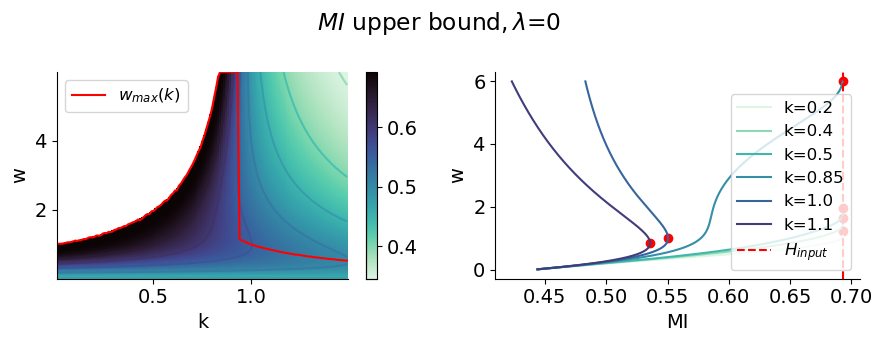

In [3]:
idx_k_to_show = [19, 39, 49, 84, 99, 109]

plt.figure(figsize=(9,3.5))

plt.subplot(1,2,1)

X, Y = np.meshgrid(ks, ws)
plt.contour(X, Y, mutual_ub, cmap='mako_r')
plt.pcolormesh(ks, ws, mutual_ub, cmap='mako_r')
plt.plot(ks, ws[np.nanargmax(mutual_ub, axis=0)], c='red', label=r'$w_{max}(k)$')

#for idx_k in idx_k_to_show: plt.axvline(ks[idx_k], ls='--', c='k')

plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')
plt.legend()

plt.subplot(1,2,2)

cs = plt.get_cmap('mako_r', len(idx_k_to_show)+2)
for tt, idx_k in enumerate(idx_k_to_show):
    plt.plot(mutual_ub[:,idx_k], ws, label=f'k={ks[idx_k]}', c=cs(tt))
    plt.scatter(np.nanmax(mutual_ub[:,idx_k]), ws[np.nanargmax(mutual_ub[:,idx_k])], c='r')
plt.axvline(entropy(p_stat), ls='--', c='r', label=r'$H_{input}$')
    
plt.ylabel('w')
plt.xlabel('MI')
plt.legend()

plt.suptitle(r'$MI \text{ upper bound}, \lambda$='+str(lmbd))
sns.despine()
plt.tight_layout()
plt.show()

# Plasticity

In [4]:
@nb.njit
def gamma_self_consistency(gamma, k, w, p, D, r, hE, hI):    
    return (p * D * w * np.exp(gamma) * (r - k*r + 2*k*w*np.exp(gamma)) / (r * (r + (k-1)*w*np.exp(gamma)) * (2*r + (k-1)*w*np.exp(gamma)))
            + p * (hI*r + np.exp(gamma)*(hE-hI)*w) * (hE*r + np.exp(gamma)*(hE-hI)*k*w) / (r**2*(r + np.exp(gamma)*(-1 + k)*w)**2)
           )
    
@nb.njit
def gamma_zeros(gamma, k, w, p, D, r, hE, hI):
    return gamma_self_consistency(gamma, k, w, p, D, r, hE, hI) - gamma

'''
def gamma_self_consistency(gamma, k, w, p, D, r, hE2, hE_hI, hI2):
    numerator = np.exp(gamma) * w * (r - k * r + 2 * np.exp(gamma) * k * w)
    denominator = (4 * r**2 + 4 * np.exp(gamma) * (-1 + k) * r * w + 
                   2 * np.exp(2 * gamma) * (1 + k**2) * w**2)
    return p * numerator / denominator
'''

def covariance(gamma, k, w, p, D, r):
    exp_gamma = np.exp(gamma)
    w_plus = (k-1)*w
    beta_plus = r + w_plus * exp_gamma
    
    return D / (r * beta_plus * (2 * r + w_plus)) * (w * exp_gamma * (r - k * r + 2 * k * w * exp_gamma))

def derivative_f(gamma, k, w, p, D, r, hE, hI, eps=1e-6):
    return (gamma_self_consistency(gamma + eps, k, w, p, D, r, hE, hI) - gamma_self_consistency(gamma - eps, k, w, p, D, r, hE, hI)) / (2 * eps)

In [5]:
k = 1.1
w = .5
r = 1
D = .1
h = 3.
p = 0.18

dd = 0.005
lmbds = np.arange(-1, 1+dd, dd)
gammas = np.arange(-10, 10+dd, dd)

LMBDS, GAMMAS = np.meshgrid(lmbds, gammas)

gamma_star = gamma_self_consistency(GAMMAS, k, w, p, D, r, h, LMBDS*h)
print(gamma_star.min(), gamma_star.max())

-1.6200000282660185 715.4601065099707


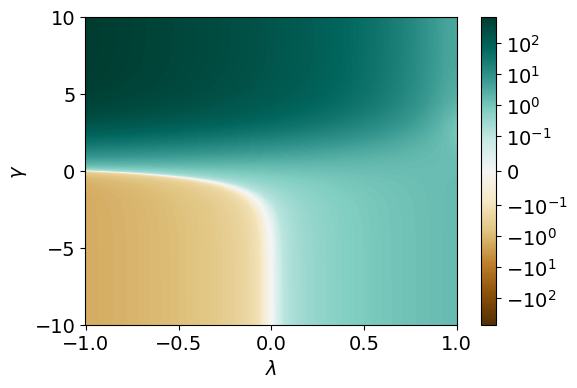

In [6]:
plt.figure(figsize=(6,4))
#plt.contour(LMBDS, GAMMAS, gamma_star, cmap='BrBG', norm=colors.SymLogNorm(linthresh=1e-1, vmin=-np.abs(gamma_star).max(), vmax=np.abs(gamma_star).max()))
plt.pcolormesh(LMBDS, GAMMAS, gamma_star, cmap='BrBG', norm=colors.SymLogNorm(linthresh=1e-1, vmin=-np.abs(gamma_star).max(), vmax=np.abs(gamma_star).max()))
plt.colorbar()
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\gamma$')
plt.show()

True
0.020142044946905722 - X stable? True - gamma stable? True
0.020142044946905725 - X stable? True - gamma stable? True
0.020142044946905725 - X stable? True - gamma stable? True


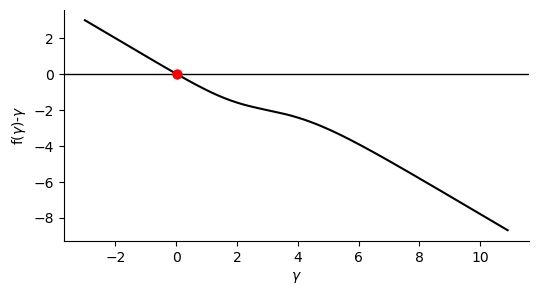

In [157]:
k = 1.1
w = 1.5
p = 0.1
r = 1.
D = .1
h = 0.
lmbd = 0.

print( k > 1 - r / w )

init_cond = [-100, -50, 0, 50, 100]

plt.figure(figsize=(6,3))

try:
    fp_1 = fixed_point(gamma_self_consistency, 0, args=(k, w, p, D, r, h, lmbd*h), maxiter=int(5e5))
    print(fp_1, '- X stable?', k > 1 - r / w / np.exp(fp_1), '- gamma stable?', derivative_f(fp_1, k, w, p, D, r,  h, lmbd*h)<1)
    
    plt.scatter(fp_1, gamma_self_consistency(fp_1, k, w, p, D, r,  h, lmbd*h) - fp_1, c='red', zorder=10)
except:
    pass
    
try:
    fp_2 = fixed_point(gamma_self_consistency, 2.5, args=(k, w, p, D, r,  h, lmbd*h), maxiter=int(5e5))
    print(fp_2, '- X stable?', k > 1 - r / w / np.exp(fp_2), '- gamma stable?', derivative_f(fp_2, k, w, p, D, r,  h, lmbd*h)<1)
    
    plt.scatter(fp_2, gamma_self_consistency(fp_2, k, w, p, D, r,  h, lmbd*h) - fp_2, c='red', zorder=10)
except:
    pass

try:
    fp_3 = fixed_point(gamma_self_consistency, 6., args=(k, w, p, D, r,  h, lmbd*h), maxiter=int(5e5))
    print(fp_3, '- X stable?', k > 1 - r / w / np.exp(fp_3), '- gamma stable?', derivative_f(fp_3, k, w, p, D, r,  h, lmbd*h)<1)
    
    plt.scatter(fp_3, gamma_self_consistency(fp_3, k, w, p, D, r,  h, lmbd*h) - fp_3, c='red', zorder=10)
except:
    pass

xx = np.arange(-3,11,0.1)

plt.plot(xx, gamma_self_consistency(xx, k, w, p, D, r,  h, lmbd*h) - xx, c='k')
plt.axhline(0, c='k', lw=1)


#plt.ylim(-0.02, 0.3)

plt.xlabel(r'$\gamma$')
plt.ylabel(r'f($\gamma$)-$\gamma$')
sns.despine()
plt.show()

In [219]:
### Grid search over h, p
k = 1.1
w = 2.5#0.2
r = 1.
D = .1
lmbd = 0

# Define params
h_min, h_max, n_h = 0, 1.5, 100
p_min, p_max, n_p = 0, 0.05, 100
gamma_min = -1e1
gamma_max = 1e2
n_gamma = int(5e5)
tol = 1e6
MAX_SOL = 3

# Generate arrays
h_values = np.linspace(h_min, h_max, n_h) #np.arange(h_min, h_max+dh, dh)
p_values = np.linspace(p_min, p_max, n_p) #np.arange(p_min, p_max+dp, dp)

hh, pp = np.meshgrid(h_values, p_values)

# Run line search on sign changes on gamma_self_consistent
gamma_range = np.linspace(gamma_min, gamma_max, n_gamma)
print('Delta gamma:', gamma_range[1]-gamma_range[0])

hh_size = hh.size
n_sol = np.zeros(hh.size)
roots_all = np.zeros((hh.size, MAX_SOL))
roots_all[:] = np.nan

def compute_roots(idx, h, p, gamma_range, k, w, D, r):
    """Function to compute the roots in parallel."""
    # Compute self-consistency
    sc = gamma_zeros(gamma_range, k, w, p, D, r, h, lmbd*h)
    sc = sc[~np.isnan(sc)]  # Remove NaNs

    # Find approximate roots based on sign changes
    sign_changes = np.where(np.diff(np.sign(sc)))[0]
    approx_roots = gamma_range[sign_changes]

    # Compute accurate solutions
    tmp_roots = np.zeros(approx_roots.size)
    
    for idx_r, root in enumerate(approx_roots):
        zeros_1 = root_scalar(gamma_zeros, args=(k, w, p, D, r, h, lmbd*h), x0=root)
        tmp_roots[idx_r] = zeros_1.root
        
    # Keep only unique roots (up to tolerance)
    tmp_roots = np.unique( np.floor(tmp_roots * tol) / tol )
    
    # Check if it is really a fixed point (i.e., gamma = self_consistency(gamma))
    # TODO

    return idx, tmp_roots  # Return index and computed roots

# Run parallel computation
results = Parallel(n_jobs=-1)(
    delayed(compute_roots)(idx, h, p, gamma_range, k, w, D, r)
    for idx, (h, p) in enumerate(tqdm(zip(hh.flatten(), pp.flatten()), total=hh_size))
)

# Store results in arrays
for idx, tmp_roots in results:
    n_sol[idx] = tmp_roots.size
    roots_all[idx, :len(tmp_roots)] = tmp_roots

Delta gamma: 0.0002200004400005895


  0%|          | 0/10000 [00:00<?, ?it/s]

In [220]:
### Switch solutions from low to high
idx_to_move = np.where(roots_all[:,0]>1)[0]
roots_all[idx_to_move,0], roots_all[idx_to_move,-1] = roots_all[idx_to_move,-1], roots_all[idx_to_move,0]

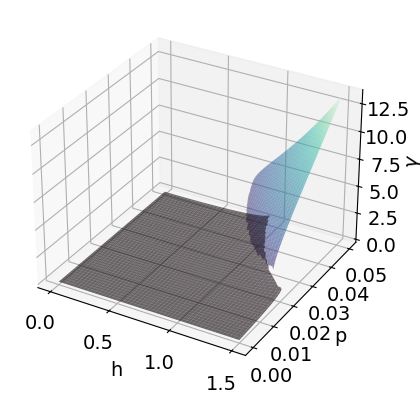

In [221]:
from mpl_toolkits.mplot3d import axes3d

ax = plt.figure().add_subplot(projection='3d')

X = hh
Y = pp
Z1 = roots_all[:,0].reshape(h_values.size, -1)
Z2 = roots_all[:,-1].reshape(h_values.size, -1)

ax.plot_surface(X, Y, Z1, cmap='mako', lw=0.5, alpha=0.6, vmin=0, vmax=np.nanmax(roots_all))
ax.plot_surface(X, Y, Z2, cmap='mako', lw=0.5, alpha=0.6, vmin=0, vmax=np.nanmax(roots_all))

ax.set_xlabel('h')
ax.set_ylabel('p')
ax.set_zlabel(r'$\gamma$')

#plt.tight_layout()
plt.show()

1 [0.027115]
1 [0.027115]
1 [0.019523]
1 [0.019523]
1 [0.005449]
1 [0.005449]
3 [0.318907 2.759543 3.380455]
3 [0.318907 2.759543 3.380455]
1 [0.197918]
1 [0.197918]
1 [0.046014]
1 [0.046014]


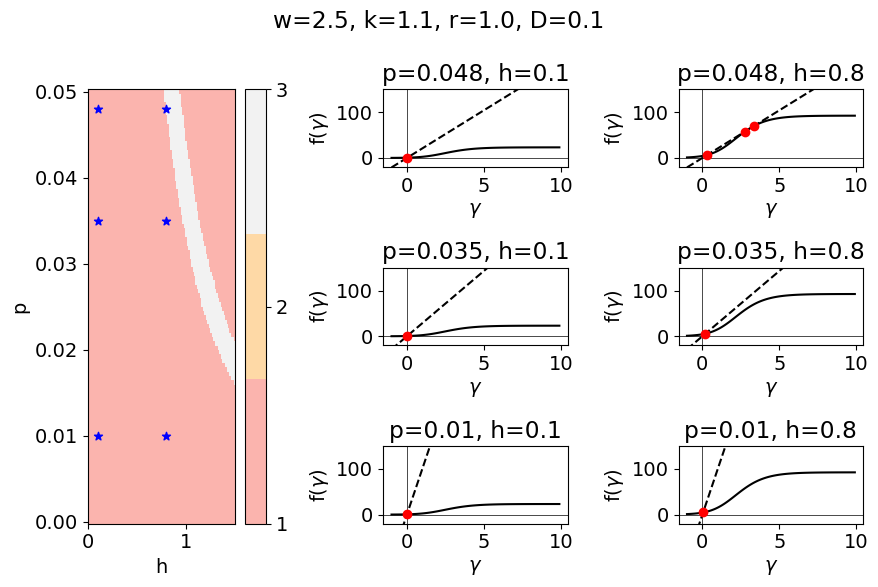

In [222]:
fig = plt.figure(figsize=(9,6))

gs = fig.add_gridspec(3, 3,  width_ratios=(1, 1, 1), height_ratios=(1, 1, 1))
                      #wspace=0.05, hspace=0.05)

### Parameter space - stable solutions plot
ax_params = fig.add_subplot(gs[:, 0])
plt.pcolormesh(h_values, p_values, n_sol.reshape(-1, h_values.size), cmap=plt.get_cmap('Pastel1', int(n_sol.max())))
cbar = plt.colorbar()
cbar.ax.locator_params(nbins=int(n_sol.max()))
#cbar.ax.set_label = 'N solutions'
plt.xlabel('h')
plt.ylabel('p')

### Parameter space - stable solutions plot
gamma_min, gamma_max = -1, 10
ymin, ymax = -20, 150

h_low = 0.1
h_high = 0.8
hs = np.array([h_low, h_high])
ps = np.array([0.01, 0.035,  0.048])[::-1] #0.048

xx = np.arange(gamma_min, gamma_max, 0.1)

for idx_h, h in enumerate(hs):
    for idx_p, p in enumerate(ps):
        ax = fig.add_subplot(gs[idx_p, idx_h+1])
        plt.plot(xx, gamma_self_consistency(xx, k, w, p, D, r, h, lmbd*h) / p, c='k')
        plt.plot(xx, xx / p, c='k', ls='--')
        ax.axhline(0, c='k', lw=0.5)
        ax.axvline(0, c='k', lw=0.5)
        ax.set_title(f'p={p}, h={h}')
        ax.set_xlabel(r'$\gamma$')
        ax.set_ylabel(r'f($\gamma$)')
        ax.set_ylim(ymin, ymax)

        ax_params.scatter(h, p, marker='*', c='blue')

        ### Find fixed points starting from IC
        # Compute self-consistency
        sc = gamma_zeros(gamma_range, k, w, p, D, r, h, lmbd*h)
        # Remove nans
        sc = sc[~np.isnan(sc)]

        # Compute approx solutions
        sign_changes = np.where(np.diff(np.sign(sc)))[0]  # Detect sign changes
        approx_roots = gamma_range[sign_changes]
        
        tmp_roots = []
        tmp_fps = []

        for root in approx_roots:
            try:
                fp_1 = fixed_point(gamma_self_consistency, root, args=(k, w, p, D, r, h, lmbd*h), maxiter=int(1e5))
                zeros_1 = root_scalar(gamma_zeros, args=(k, w, p, D, r, h, lmbd*h), x0=root)
                
                ax.scatter(fp_1, gamma_self_consistency(fp_1, k, w, p, D, r, h, lmbd*h) / p, c='red', zorder=10)
                
                tmp_fps.append(fp_1)
                tmp_roots.append(zeros_1.root)
            except:
                pass
            
        tmp_roots = np.array(tmp_roots)
        tmp_roots = np.unique( np.floor(tmp_roots * tol) / tol )
        print(tmp_roots.size, tmp_roots)
        
        tmp_fps = np.array(tmp_fps)
        tmp_fps = np.unique( np.floor(tmp_fps * tol) / tol )
        print(tmp_fps.size, tmp_fps)
                
plt.suptitle(f'w={w}, k={k}, r={r}, D={D}')
plt.tight_layout()
plt.savefig(f'figures/gamma_sc_w={w}, k={k}, r={r}, D={D}_hmax_{h_max}.pdf', bbox_inches='tight')
plt.show()

In [223]:
### Grid search over h, p
k = 1.1
w = 2.5#0.2
r = 1.
D = .1
lmbd = -1

# Define params
h_min, h_max, n_h = 0, 1.5, 100
p_min, p_max, n_p = 0, 0.05, 100
gamma_min = -1e1
gamma_max = 1e2
n_gamma = int(5e5)
tol = 1e6
MAX_SOL = 3

# Generate arrays
h_values = np.linspace(h_min, h_max, n_h) #np.arange(h_min, h_max+dh, dh)
p_values = np.linspace(p_min, p_max, n_p) #np.arange(p_min, p_max+dp, dp)

hh, pp = np.meshgrid(h_values, p_values)

# Run line search on sign changes on gamma_self_consistent
gamma_range = np.linspace(gamma_min, gamma_max, n_gamma)
print('Delta gamma:', gamma_range[1]-gamma_range[0])

hh_size = hh.size
n_sol = np.zeros(hh.size)
roots_all = np.zeros((hh.size, MAX_SOL))
roots_all[:] = np.nan

def compute_roots(idx, h, p, gamma_range, k, w, D, r):
    """Function to compute the roots in parallel."""
    # Compute self-consistency
    sc = gamma_zeros(gamma_range, k, w, p, D, r, h, lmbd*h)
    sc = sc[~np.isnan(sc)]  # Remove NaNs

    # Find approximate roots based on sign changes
    sign_changes = np.where(np.diff(np.sign(sc)))[0]
    approx_roots = gamma_range[sign_changes]

    # Compute accurate solutions
    tmp_roots = np.zeros(approx_roots.size)
    
    for idx_r, root in enumerate(approx_roots):
        zeros_1 = root_scalar(gamma_zeros, args=(k, w, p, D, r, h, lmbd*h), x0=root)
        tmp_roots[idx_r] = zeros_1.root
        
    # Keep only unique roots (up to tolerance)
    tmp_roots = np.unique( np.floor(tmp_roots * tol) / tol )
    
    # Check if it is really a fixed point (i.e., gamma = self_consistency(gamma))
    # TODO

    return idx, tmp_roots  # Return index and computed roots

# Run parallel computation
results = Parallel(n_jobs=-1)(
    delayed(compute_roots)(idx, h, p, gamma_range, k, w, D, r)
    for idx, (h, p) in enumerate(tqdm(zip(hh.flatten(), pp.flatten()), total=hh_size))
)

# Store results in arrays
for idx, tmp_roots in results:
    n_sol[idx] = tmp_roots.size
    roots_all[idx, :len(tmp_roots)] = tmp_roots

Delta gamma: 0.0002200004400005895


  0%|          | 0/10000 [00:00<?, ?it/s]

In [224]:
### Switch solutions from low to high
idx_to_move = np.where(roots_all[:,0]>1)[0]
roots_all[idx_to_move,0], roots_all[idx_to_move,-1] = roots_all[idx_to_move,-1], roots_all[idx_to_move,0]

1 [0.032805]
1 [0.032805]
1 [0.023548]
1 [0.023548]
1 [0.006536]
1 [0.006536]
1 [14.572743]
1 [14.572743]
1 [10.623852]
1 [10.623852]
1 [0.140603]
1 [0.140603]


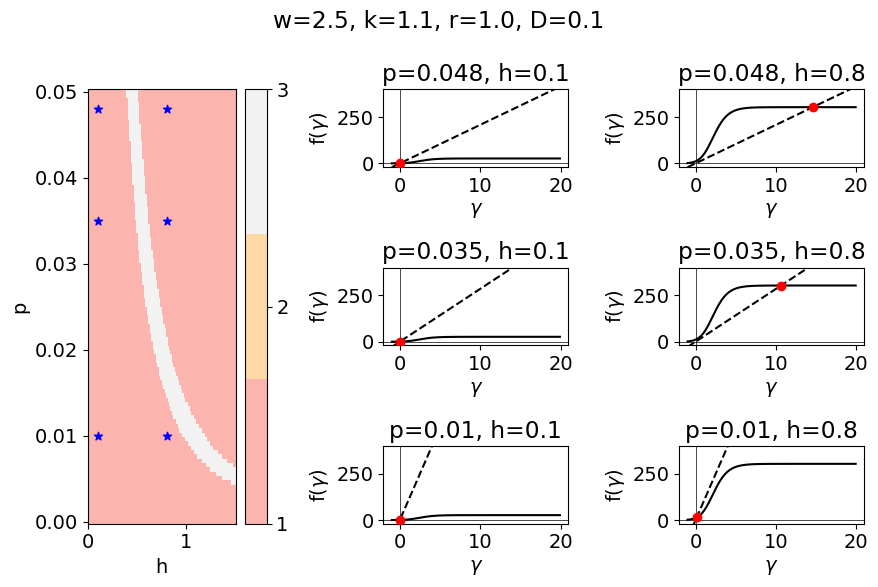

In [229]:
fig = plt.figure(figsize=(9,6))

gs = fig.add_gridspec(3, 3,  width_ratios=(1, 1, 1), height_ratios=(1, 1, 1))
                      #wspace=0.05, hspace=0.05)

### Parameter space - stable solutions plot
ax_params = fig.add_subplot(gs[:, 0])
plt.pcolormesh(h_values, p_values, n_sol.reshape(-1, h_values.size), cmap=plt.get_cmap('Pastel1', int(n_sol.max())))
cbar = plt.colorbar()
cbar.ax.locator_params(nbins=int(n_sol.max()))
#cbar.ax.set_label = 'N solutions'
plt.xlabel('h')
plt.ylabel('p')

### Parameter space - stable solutions plot
gamma_min, gamma_max = -1, 20
ymin, ymax = -20, 400

h_low = 0.1
h_high = 0.8
hs = np.array([h_low, h_high])
ps = np.array([0.01, 0.035,  0.048])[::-1] #0.048

xx = np.arange(gamma_min, gamma_max, 0.1)

for idx_h, h in enumerate(hs):
    for idx_p, p in enumerate(ps):
        ax = fig.add_subplot(gs[idx_p, idx_h+1])
        plt.plot(xx, gamma_self_consistency(xx, k, w, p, D, r, h, lmbd*h) / p, c='k')
        plt.plot(xx, xx / p, c='k', ls='--')
        ax.axhline(0, c='k', lw=0.5)
        ax.axvline(0, c='k', lw=0.5)
        ax.set_title(f'p={p}, h={h}')
        ax.set_xlabel(r'$\gamma$')
        ax.set_ylabel(r'f($\gamma$)')
        ax.set_ylim(ymin, ymax)

        ax_params.scatter(h, p, marker='*', c='blue')

        ### Find fixed points starting from IC
        # Compute self-consistency
        sc = gamma_zeros(gamma_range, k, w, p, D, r, h, lmbd*h)
        # Remove nans
        sc = sc[~np.isnan(sc)]

        # Compute approx solutions
        sign_changes = np.where(np.diff(np.sign(sc)))[0]  # Detect sign changes
        approx_roots = gamma_range[sign_changes]
        
        tmp_roots = []
        tmp_fps = []

        for root in approx_roots:
            try:
                fp_1 = fixed_point(gamma_self_consistency, root, args=(k, w, p, D, r, h, lmbd*h), maxiter=int(1e5))
                zeros_1 = root_scalar(gamma_zeros, args=(k, w, p, D, r, h, lmbd*h), x0=root)
                
                ax.scatter(fp_1, gamma_self_consistency(fp_1, k, w, p, D, r, h, lmbd*h) / p, c='red', zorder=10)
                
                tmp_fps.append(fp_1)
                tmp_roots.append(zeros_1.root)
            except:
                pass
            
        tmp_roots = np.array(tmp_roots)
        tmp_roots = np.unique( np.floor(tmp_roots * tol) / tol )
        print(tmp_roots.size, tmp_roots)
        
        tmp_fps = np.array(tmp_fps)
        tmp_fps = np.unique( np.floor(tmp_fps * tol) / tol )
        print(tmp_fps.size, tmp_fps)
                
plt.suptitle(f'w={w}, k={k}, r={r}, D={D}')
plt.tight_layout()
plt.savefig(f'figures/gamma_sc_w={w}, k={k}, r={r}, D={D}_hmax_{h_max}.pdf', bbox_inches='tight')
plt.show()

In [7]:
### Grid search over h, p
k = 1.1
w = .5
r = 1
D = .1
h = 3.
p = 0.18

lmbd = -1


# Define params
h_min, h_max, n_h = 0, 3, 100
p_min, p_max, n_p = 0, 0.2, 100
gamma_min = -1e1
gamma_max = 5e3
n_gamma = int(5e5)
tol = 1e6
MAX_SOL = 4

# Generate arrays
h_values = np.linspace(h_min, h_max, n_h) #np.arange(h_min, h_max+dh, dh)
p_values = np.linspace(p_min, p_max, n_p) #np.arange(p_min, p_max+dp, dp)

hh, pp = np.meshgrid(h_values, p_values)

# Run line search on sign changes on gamma_self_consistent
gamma_range = np.linspace(gamma_min, gamma_max, n_gamma)
print('Delta gamma:', gamma_range[1]-gamma_range[0])

hh_size = hh.size
n_sol = np.zeros(hh.size)
roots_all = np.zeros((hh.size, MAX_SOL))
roots_all[:] = np.nan

def compute_roots(idx, h, p, gamma_range, k, w, D, r):
    """Function to compute the roots in parallel."""
    # Compute self-consistency
    sc = gamma_zeros(gamma_range, k, w, p, D, r, h, lmbd*h)
    sc = sc[~np.isnan(sc)]  # Remove NaNs

    # Find approximate roots based on sign changes
    sign_changes = np.where(np.diff(np.sign(sc)))[0]
    approx_roots = gamma_range[sign_changes]
    #approx_roots = np.concatenate([[gamma_min], approx_roots, [gamma_max]])

    # Compute accurate solutions
    tmp_roots = np.zeros(approx_roots.size)
    
    for idx_r, root in enumerate(approx_roots):
        zeros_1 = root_scalar(gamma_zeros, args=(k, w, p, D, r, h, lmbd*h), x0=root)
        tmp_roots[idx_r] = zeros_1.root
        
    # Keep only unique roots (up to tolerance)
    tmp_roots = np.unique( np.floor(tmp_roots * tol) / tol )
    
    # Check if it is really a fixed point (i.e., gamma = self_consistency(gamma))
    #np.where( tmp_roots -  )[0]

    return idx, tmp_roots  # Return index and computed roots

# Run parallel computation
results = Parallel(n_jobs=-1)(
    delayed(compute_roots)(idx, h, p, gamma_range, k, w, D, r)
    for idx, (h, p) in enumerate(tqdm(zip(hh.flatten(), pp.flatten()), total=hh_size))
)

# Store results in arrays
for idx, tmp_roots in results:
    n_sol[idx] = tmp_roots.size
    roots_all[idx, :len(tmp_roots)] = tmp_roots

Delta gamma: 0.010020020040039768


  0%|          | 0/10000 [00:00<?, ?it/s]

2 [4.2310000e-03 1.3694681e+01]
1 [0.004231]
1 [0.002103]
1 [0.002103]
1 [0.000232]
1 [0.000232]
2 [-1.298054 -0.002474]
2 [-1.298054 -0.002474]
3 [-3.29592000e-01 -6.13900000e-03  3.12443999e+02]
3 [-3.29592000e-01 -6.13900000e-03  3.12443999e+02]
3 [2.7300000e-04 1.8037630e+00 3.4715999e+01]
3 [2.7300000e-04 1.8037630e+00 3.4715999e+01]


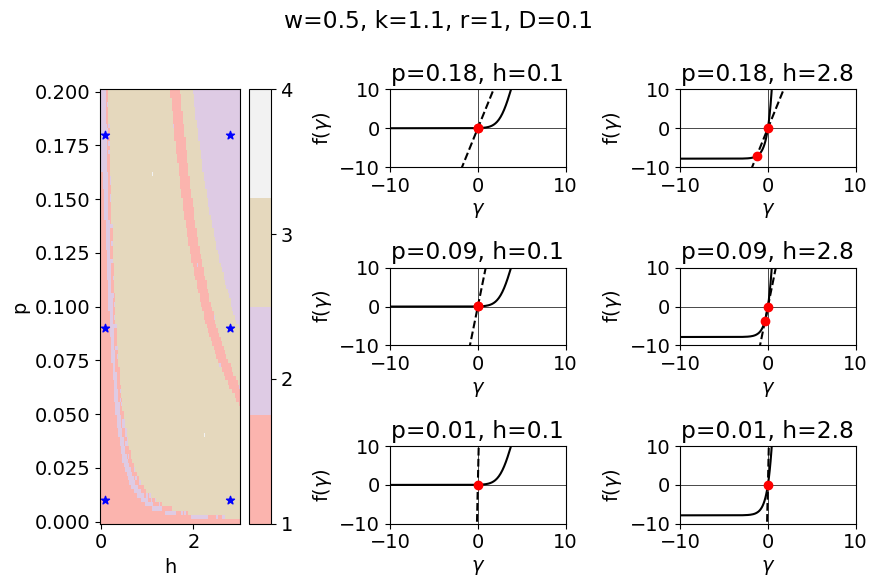

In [12]:
fig = plt.figure(figsize=(9,6))

gs = fig.add_gridspec(3, 3,  width_ratios=(1, 1, 1), height_ratios=(1, 1, 1))
                      #wspace=0.05, hspace=0.05)

### Parameter space - stable solutions plot
ax_params = fig.add_subplot(gs[:, 0])
plt.pcolormesh(h_values, p_values, n_sol.reshape(-1, h_values.size), cmap=plt.get_cmap('Pastel1', int(n_sol.max())))
cbar = plt.colorbar()
cbar.ax.locator_params(nbins=int(n_sol.max()))
#cbar.ax.set_label = 'N solutions'
plt.xlabel('h')
plt.ylabel('p')

### Parameter space - stable solutions plot
gamma_min, gamma_max = -10, 20
ymin, ymax = -20, 400

h_low = 0.1
h_high = 2.8
hs = np.array([h_low, h_high])
ps = np.array([0.01, 0.09,  0.18])[::-1] #0.048

xx = np.arange(gamma_min, gamma_max, 0.1)

for idx_h, h in enumerate(hs):
    for idx_p, p in enumerate(ps):
        ax = fig.add_subplot(gs[idx_p, idx_h+1])
        plt.plot(xx, gamma_self_consistency(xx, k, w, p, D, r, h, lmbd*h) / p, c='k')
        plt.plot(xx, xx / p, c='k', ls='--')
        ax.axhline(0, c='k', lw=0.5)
        ax.axvline(0, c='k', lw=0.5)
        ax.set_title(f'p={p}, h={h}')
        ax.set_xlabel(r'$\gamma$')
        ax.set_ylabel(r'f($\gamma$)')
        ax.set_ylim(ymin, ymax)

        ax_params.scatter(h, p, marker='*', c='blue')

        ### Find fixed points starting from IC
        # Compute self-consistency
        sc = gamma_zeros(gamma_range, k, w, p, D, r, h, lmbd*h)
        # Remove nans
        sc = sc[~np.isnan(sc)]

        # Compute approx solutions
        sign_changes = np.where(np.diff(np.sign(sc)))[0]  # Detect sign changes
        approx_roots = gamma_range[sign_changes]
        
        tmp_roots = []
        tmp_fps = []

        for root in approx_roots:
            try:
                fp_1 = fixed_point(gamma_self_consistency, root, args=(k, w, p, D, r, h, lmbd*h), maxiter=int(1e5))
                zeros_1 = root_scalar(gamma_zeros, args=(k, w, p, D, r, h, lmbd*h), x0=root)
                
                ax.scatter(fp_1, gamma_self_consistency(fp_1, k, w, p, D, r, h, lmbd*h) / p, c='red', zorder=10)
                
                tmp_fps.append(fp_1)
                tmp_roots.append(zeros_1.root)
            except:
                pass
            
        tmp_roots = np.array(tmp_roots)
        tmp_roots = np.unique( np.floor(tmp_roots * tol) / tol )
        print(tmp_roots.size, tmp_roots)
        
        tmp_fps = np.array(tmp_fps)
        tmp_fps = np.unique( np.floor(tmp_fps * tol) / tol )
        print(tmp_fps.size, tmp_fps)
        
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 10)
                
plt.suptitle(f'w={w}, k={k}, r={r}, D={D}')
plt.tight_layout()
plt.savefig(f'figures/gamma_sc_w={w}, k={k}, r={r}, D={D}_hmax_{h_max}.pdf', bbox_inches='tight')
plt.show()

In [105]:
### Grid search over h, p
k = 1.1
w = 0.3
r = 1.
D = 1.

# Define params
h_min, h_max, n_h = 0, 1, 100
p_min, p_max, n_p = 0, 0.2, 100
gamma_min = -1e1
gamma_max = 1e3
n_gamma = int(2e5)

# Generate arrays
h_values = np.linspace(h_min, h_max, n_h)#np.arange(h_min, h_max+dh, dh)
p_values = np.linspace(p_min, p_max, n_p)#np.arange(p_min, p_max+dp, dp)

hh, pp = np.meshgrid(h_values, p_values)

# Run line search on sign changes on gamma_self_consistent
gamma_range = np.linspace(gamma_min, gamma_max, n_gamma)
print('Delta gamma:', gamma_range[1]-gamma_range[0])

n_sol = np.zeros(hh.size)
roots_all = np.zeros((hh.size, 3))
roots_all[:] = np.nan

for idx, (h, p) in enumerate(tqdm(zip(hh.flatten(), pp.flatten()), total=hh.size)):
    ### Run grid search on sign changes
    # Compute self-consistency
    sc = gamma_zeros(gamma_range, k, w, p, D, r, h**2, 0, 0)
    # Remove nans
    sc = sc[~np.isnan(sc)]

    # Compute approx solutions
    sign_changes = np.where(np.diff(np.sign(sc)))[0]  # Detect sign changes
    approx_roots = gamma_range[sign_changes]
    #print('Approx solutions:', approx_roots)
    
    # Add fake approx solutions
    #approx_roots = np.concatenate([approx_roots, [0, 1, 5, 10]])
    
    ### Compute correct solutions
    tmp_roots = np.zeros(approx_roots.size)
    tmp_fps = np.zeros(approx_roots.size)
    
    for idx_r, root in enumerate(approx_roots):
        zeros_1 = root_scalar(gamma_zeros, args=(k, w, p, D, r, h**2, 0, 0), x0=root)
        #print(zeros_1.root, 'converged?', zeros_1.converged)
        #tmp_roots.append([zeros_1.root, zeros_1.converged])
        tmp_roots[idx_r] = zeros_1.root
    
    tmp_roots = np.unique(tmp_roots)
    
    # Store results
    n_sol[idx] = tmp_roots.size
    roots_all[idx, :int(n_sol[idx])] = tmp_roots

Delta gamma: 0.005050025250126211


  0%|          | 0/10000 [00:00<?, ?it/s]

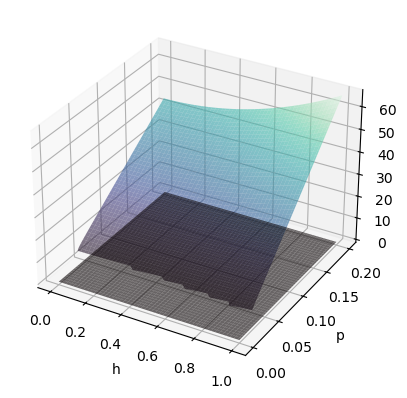

In [106]:
from mpl_toolkits.mplot3d import axes3d

ax = plt.figure().add_subplot(projection='3d')

X = hh
Y = pp
Z1 = roots_all[:,0].reshape(h_values.size, -1)
Z2 = roots_all[:,-1].reshape(h_values.size, -1)

ax.plot_surface(X, Y, Z1, cmap='mako', lw=0.5, alpha=0.6, vmin=0, vmax=np.nanmax(roots_all))
ax.plot_surface(X, Y, Z2, cmap='mako', lw=0.5, alpha=0.6, vmin=0, vmax=np.nanmax(roots_all))

ax.set_xlabel('h')
ax.set_ylabel('p')
ax.set_zlabel(r'$\gamma$')

#plt.tight_layout()
plt.show()

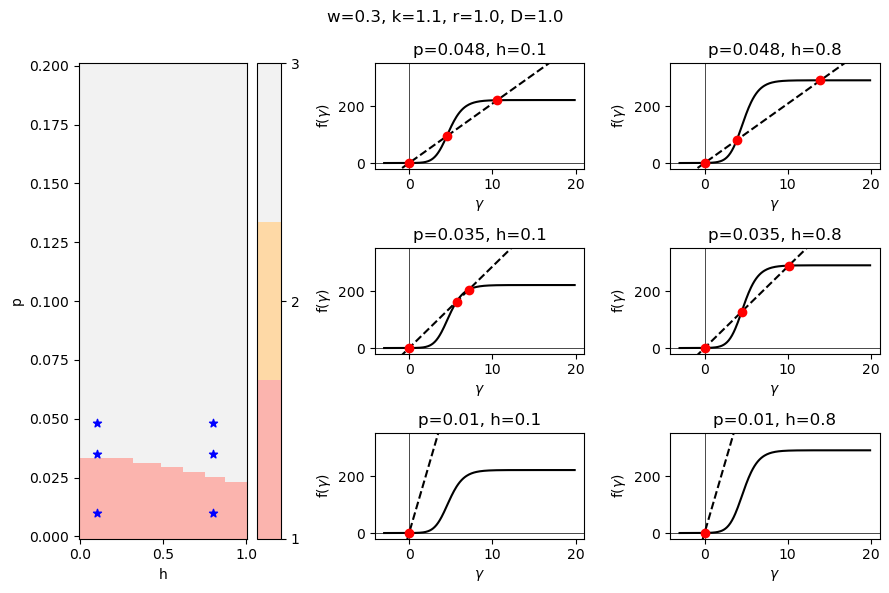

In [107]:
fig = plt.figure(figsize=(9,6))

gs = fig.add_gridspec(3, 3,  width_ratios=(1, 1, 1), height_ratios=(1, 1, 1))
                      #wspace=0.05, hspace=0.05)

### Parameter space - stable solutions plot
ax_params = fig.add_subplot(gs[:, 0])
plt.pcolormesh(h_values, p_values, n_sol.reshape(-1, h_values.size), cmap=plt.get_cmap('Pastel1', int(n_sol.max())))
cbar = plt.colorbar()
cbar.ax.locator_params(nbins=int(n_sol.max()))
#cbar.ax.set_label = 'N solutions'
plt.xlabel('h')
plt.ylabel('p')

### Parameter space - stable solutions plot
xx = np.arange(-3,20,0.1)
ps = np.array([0.01, 0.035, 0.048])[::-1]
ymin, ymax = -20, 350

h_low = 0.1
h_high = 0.8
hs = np.array([h_low, h_high])

for idx_h, h in enumerate(hs):
    for idx_p, p in enumerate(ps):
        ax = fig.add_subplot(gs[idx_p, idx_h+1])
        plt.plot(xx, gamma_self_consistency(xx, k, w, p, D, r, h**2, 0, 0) / p, c='k')
        plt.plot(xx, xx / p, c='k', ls='--')
        ax.axhline(0, c='k', lw=0.5)
        ax.axvline(0, c='k', lw=0.5)
        ax.set_title(f'p={p}, h={h}')
        ax.set_xlabel(r'$\gamma$')
        ax.set_ylabel(r'f($\gamma$)')
        ax.set_ylim(ymin, ymax)

        ax_params.scatter(h, p, marker='*', c='blue')

        ### Find fixed points starting from IC
        # Compute self-consistency
        sc = gamma_zeros(gamma_range, k, w, p, D, r, h**2, 0, 0)
        # Remove nans
        sc = sc[~np.isnan(sc)]

        # Compute approx solutions
        sign_changes = np.where(np.diff(np.sign(sc)))[0]  # Detect sign changes
        approx_roots = gamma_range[sign_changes]

        for root in approx_roots:
            try:
                fp_1 = fixed_point(gamma_self_consistency, root, args=(k, w, p, D, r, h**2, 0, 0), maxiter=int(5e5))
                ax.scatter(fp_1, gamma_self_consistency(fp_1, k, w, p, D, r, h**2, 0, 0) / p, c='red', zorder=10)
            except:
                pass
    
plt.suptitle(f'w={w}, k={k}, r={r}, D={D}')
plt.tight_layout()
plt.savefig(f'figures/gamma_sc_w={w}, k={k}, r={r}, D={D}_hmax_{h_max}.pdf', bbox_inches='tight')
plt.show()

In [5]:
### Grid search over w, p
k = 1.1
r = 1.
D = .1
h = .25

# Define params
w_min, w_max, n_w = 0, 1.5, 100
p_min, p_max, n_p = 0, 1, 200
gamma_min = -1e1
gamma_max = 1e3
n_gamma = int(5e5)

# Generate arrays
w_values = np.linspace(w_min, w_max, n_w)#np.arange(h_min, h_max+dh, dh)
p_values = np.linspace(p_min, p_max, n_p)#np.arange(p_min, p_max+dp, dp)

ww, pp = np.meshgrid(w_values, p_values)

# Run line search on sign changes on gamma_self_consistent
gamma_range = np.linspace(gamma_min, gamma_max, n_gamma)
print('Delta gamma:', gamma_range[1]-gamma_range[0])

n_sol = np.zeros(pp.size)
roots_all = np.zeros((pp.size, 3))
roots_all[:] = np.nan

def compute_roots(idx, h, p, gamma_range, k, w, D, r):
    """Function to compute the roots in parallel."""
    # Compute self-consistency
    sc = gamma_zeros(gamma_range, k, w, p, D, r, h**2, 0, 0)
    sc = sc[~np.isnan(sc)]  # Remove NaNs

    # Find approximate roots based on sign changes
    sign_changes = np.where(np.diff(np.sign(sc)))[0]
    approx_roots = gamma_range[sign_changes]

    # Compute accurate solutions
    tmp_roots = np.zeros(approx_roots.size)
    
    for idx_r, root in enumerate(approx_roots):
        zeros_1 = root_scalar(gamma_zeros, args=(k, w, p, D, r, h**2, 0, 0), x0=root)
        tmp_roots[idx_r] = zeros_1.root

    tmp_roots = np.unique(tmp_roots)  # Keep only unique roots

    return idx, tmp_roots  # Return index and computed roots

# Run parallel computation
results = Parallel(n_jobs=-1)(
    delayed(compute_roots)(idx, h, p, gamma_range, k, w, D, r)
    for idx, (w, p) in enumerate(tqdm(zip(ww.flatten(), pp.flatten()), total=pp.size))
)

# Store results in arrays
for idx, tmp_roots in results:
    n_sol[idx] = tmp_roots.size
    roots_all[idx, :len(tmp_roots)] = tmp_roots

Delta gamma: 0.0020200040400073505


  0%|          | 0/20000 [00:00<?, ?it/s]

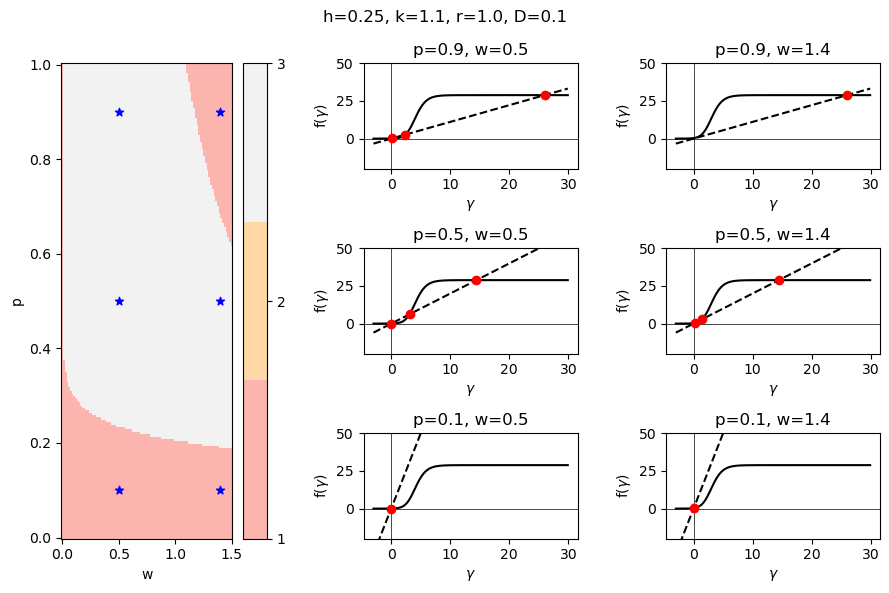

In [6]:
fig = plt.figure(figsize=(9,6))

gs = fig.add_gridspec(3, 3,  width_ratios=(1, 1, 1), height_ratios=(1, 1, 1))
                      #wspace=0.05, hspace=0.05)

### Parameter space - stable solutions plot
ax_params = fig.add_subplot(gs[:, 0])
plt.pcolormesh(ww, pp, n_sol.reshape(p_values.size,-1), cmap=plt.get_cmap('Pastel1', int(n_sol.max())))
cbar = plt.colorbar()
cbar.ax.locator_params(nbins=int(n_sol.max()))
#cbar.ax.set_label = 'N solutions'
plt.xlabel('w')
plt.ylabel('p')

### Parameter space - stable solutions plot
xx = np.arange(-3,30,0.1)
ps = np.array([0.1, 0.5, 0.9])[::-1]
ymin, ymax = -20, 50

ws = np.array([0.5, 1.4])

for idx_w, w in enumerate(ws):
    for idx_p, p in enumerate(ps):
        ax = fig.add_subplot(gs[idx_p, idx_w+1])
        plt.plot(xx, gamma_self_consistency(xx, k, w, p, D, r, h**2, 0, 0) / p, c='k')
        plt.plot(xx, xx / p, c='k', ls='--')
        ax.axhline(0, c='k', lw=0.5)
        ax.axvline(0, c='k', lw=0.5)
        ax.set_title(f'p={p}, w={w}')
        ax.set_xlabel(r'$\gamma$')
        ax.set_ylabel(r'f($\gamma$)')
        ax.set_ylim(ymin, ymax)

        ax_params.scatter(w, p, marker='*', c='blue')

        ### Find fixed points starting from IC
        # Compute self-consistency
        sc = gamma_zeros(gamma_range, k, w, p, D, r, h**2, 0, 0)
        # Remove nans
        sc = sc[~np.isnan(sc)]

        # Compute approx solutions
        sign_changes = np.where(np.diff(np.sign(sc)))[0]  # Detect sign changes
        approx_roots = gamma_range[sign_changes]

        for root in approx_roots:
            try:
                fp_1 = fixed_point(gamma_self_consistency, root, args=(k, w, p, D, r, h**2, 0, 0), maxiter=int(5e5))
                ax.scatter(fp_1, gamma_self_consistency(fp_1, k, w, p, D, r, h**2, 0, 0) / p, c='red', zorder=10)
            except:
                pass
    
plt.suptitle(f'h={h}, k={k}, r={r}, D={D}')
plt.tight_layout()
#plt.savefig(f'figures/gamma_sc_w={w}, k={k}, r={r}, D={D}_hmax_{h_max}.pdf', bbox_inches='tight')
plt.show()

In [7]:
### Switch solutions from low to high
idx_to_move = np.where(roots_all[:,0]>1)[0]
roots_all[idx_to_move,0], roots_all[idx_to_move,-1] = roots_all[idx_to_move,-1], roots_all[idx_to_move,0]

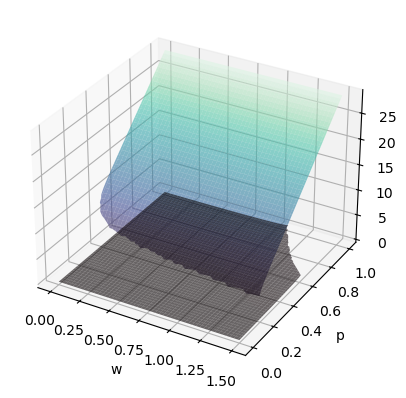

In [8]:
ax = plt.figure().add_subplot(projection='3d')

X = ww
Y = pp
Z1 = roots_all[:,0].reshape(p_values.size, -1)
Z2 = roots_all[:,-1].reshape(p_values.size, -1)

ax.plot_surface(X, Y, Z1, cmap='mako', lw=0.5, alpha=0.6, vmin=0, vmax=np.nanmax(roots_all))
ax.plot_surface(X, Y, Z2, cmap='mako', lw=0.5, alpha=0.6, vmin=0, vmax=np.nanmax(roots_all))

ax.set_xlabel('w')
ax.set_ylabel('p')
ax.set_zlabel(r'$\gamma$')

#plt.tight_layout()
plt.show()

# Compute bounds on mutual

In [11]:
### Info input
M = 2
tau_h = 1
wup = 1 / tau_h
wdown = 1 / tau_h
delta_h = 0.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

idxs_gamma = np.array([0,2])
mutual_ub = np.zeros_like(roots_all)
mutual_ub[:] = np.nan

delta = np.zeros_like(roots_all)
delta[:] = np.nan

for which in idxs_gamma:
    for idx, (w, p) in enumerate(tqdm(zip(ww.flatten(), pp.flatten()), total=pp.size)):
        ### Check that gamma exist
        if np.isnan(roots_all[idx,which]): continue

        ### Create gammas
        gs = np.zeros(M) + np.exp( roots_all[idx,which] )

        ### Compute upper bound
        mutual_ub[idx,which] = theo_ub(w, k, r, D, p_stat, gs, hs)
        
        #delta[idx,which] = mutual_ub[idx,which] - theo_ub(w, k, r, D, p_stat, np.ones(M), hs)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [17]:
w_values.shape, p_values.shape

((100,), (200,))

In [21]:
np.nanargmax(Z1, axis=0)

(100,)

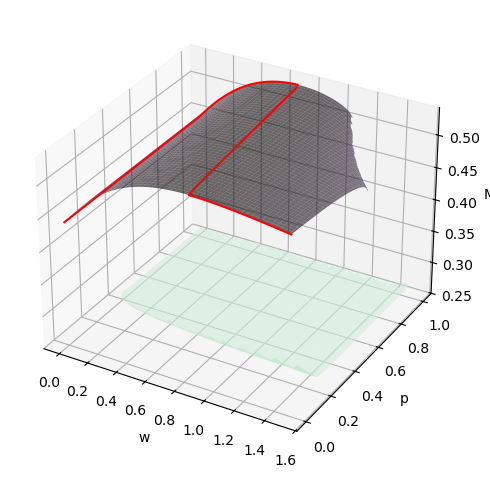

In [23]:
ax = plt.figure().add_subplot(projection='3d')

X = ww
Y = pp
Z1 = mutual_ub[:,0].reshape(p_values.size, -1)
Z2 = mutual_ub[:,-1].reshape(p_values.size, -1)

ax.plot_surface(X, Y, Z1, cmap='mako_r', lw=0.5, alpha=0.6, vmin=np.nanmin(mutual_ub), vmax=np.nanmax(mutual_ub))
ax.plot_surface(X, Y, Z2, cmap='mako_r', lw=0.5, alpha=0.6, vmin=np.nanmin(mutual_ub), vmax=np.nanmax(mutual_ub))

idx_max = np.nanargmax(Z1, axis=0)
p_max = p_values[idx_max]
mutual_max = np.nanmax(Z1, axis=0)
#print('w_max:', w_max, ', p_max:', p_max, ', MI_max:', mutual_max)
ax.plot(w_values, p_max, mutual_max, c='red', zorder=10)

'''
idx_max = np.nanargmax(mutual_ub[:,2])
p_max = pp.flatten()[idx_max]
w_max = ww.flatten()[idx_max]
mutual_max = np.nanmax(mutual_ub[:,2])
print('w_max:', w_max, ', p_max:', p_max, ', MI_max:', mutual_max)
ax.scatter(w_max, p_max, mutual_max, c='red')
'''

#ax.scatter(X, Y, Z1)
#ax.scatter(X, Y, Z2)

ax.set_xlabel('w')
ax.set_ylabel('p')
ax.set_zlabel('MI')

plt.tight_layout()
plt.show()

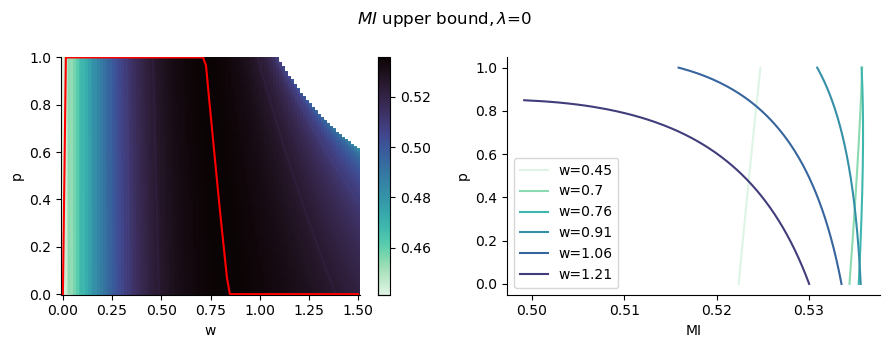

In [27]:
idx_w_to_show = [30, 46, 50, 60, 70, 80]

plt.figure(figsize=(9,3.5))

plt.subplot(1,2,1)

plt.contour(X, Y, Z1, cmap='mako_r')
plt.pcolormesh(X, Y, Z1, cmap='mako_r')
plt.colorbar()
plt.plot(w_values, p_max, c='red', zorder=10)
plt.xlabel('w')
plt.ylabel('p')

plt.subplot(1,2,2)

cs = plt.get_cmap('mako_r', len(idx_w_to_show)+2)
for tt, idx_w in enumerate(idx_w_to_show):
    plt.plot(Z1[:,idx_w], p_values, label=f'w={round(w_values[idx_w],2)}', c=cs(tt))
    #plt.scatter(np.nanmax(Z1[idx_w]), p_values[np.nanargmax(Z1[idx_w])], c='r')
#plt.axvline(entropy(p_stat), ls='--', c='r', label=r'$H_{input}$')
    
plt.ylabel('p')
plt.xlabel('MI')
plt.legend()

plt.suptitle(r'$MI \text{ upper bound}, \lambda$='+str(lmdb))
sns.despine()
plt.tight_layout()
plt.show()

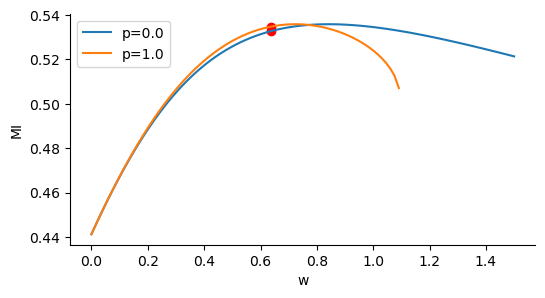

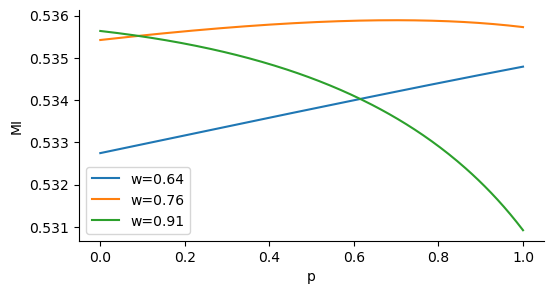

In [13]:
idx_w = 42

plt.figure(figsize=(6,3))
idx_p = 0
plt.plot(w_values, Z1[idx_p], label=f'p={p_values[idx_p]}')
plt.scatter(w_values[idx_w], Z1[idx_p][idx_w], c='red')
idx_p = -1
plt.plot(w_values, Z1[idx_p], label=f'p={p_values[idx_p]}')
plt.scatter(w_values[idx_w], Z1[idx_p][idx_w], c='red')
plt.xlabel('w')
plt.ylabel('MI')
plt.legend()
sns.despine()
plt.show()

plt.figure(figsize=(6,3))
idx_w = 42
plt.plot(p_values, Z1[:,idx_w], label=f'w={round(w_values[idx_w],2)}')
idx_w = 50
plt.plot(p_values, Z1[:,idx_w], label=f'w={round(w_values[idx_w],2)}')
idx_w = 60
plt.plot(p_values, Z1[:,idx_w], label=f'w={round(w_values[idx_w],2)}')
plt.xlabel('p')
plt.ylabel('MI')
plt.legend()
sns.despine()
plt.show()

# Run stochastic simulations

In [2]:
from utils.simulation import *
from utils import plotting

In [3]:
def get_default_params_system():
    ### Info system
    N = 2
    w = 2
    k = 1.1
    tau_ei = .01
    tau_p = 1000.
    p = .025
    r = np.ones(N)
    D = 1.
    
    return {'N': N, 'w': w, 'k': k, 'tau_ei': tau_ei, 'r': r, 'tau_p': tau_p, 'p': p, 'D': D}

In [7]:
### Info input
M = 1 #3
tau_h = 80
wup = 1 / tau_h
wdown = 1 / tau_h
delta_h = .5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

### Info simulation
steps = int(1e6)
dt = 0.0001

### Create info dictionary
info_input = create_info_input(W, hs)
info_simulation = create_info_simulation(steps,dt)

In [8]:
info_system = create_info_system(**get_default_params_system())

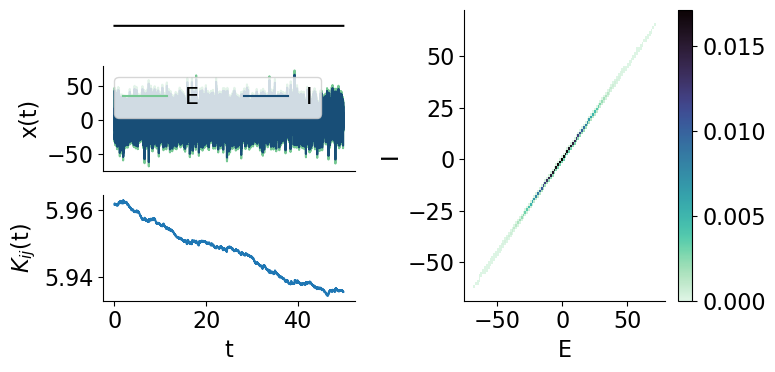

In [9]:
inputs, states = simulate_coupled_system(info_system, info_input, info_simulation, linear=True, seed=None)
states, plasticity = states

plotting.plot_simulation(states, inputs, plasticity, hs[0], dt, max_steps_to_plot = int(5e5))

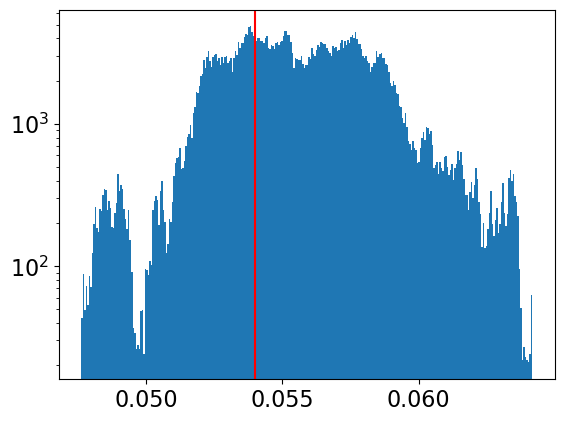

In [51]:
plt.hist(plasticity[-int(5e5):], bins=300)
plt.axvline(0.054003975083638786, c='red')
plt.yscale('log')
plt.show()

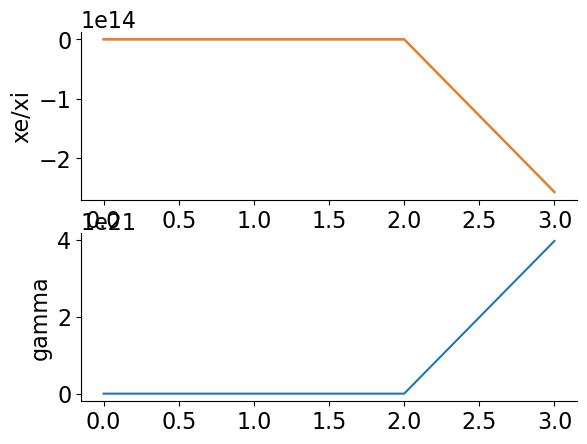

In [12]:
tmax = np.where(np.isnan(states[:,0]))[0][0] -30

plt.subplot(2,1,1)
plt.plot( states[:tmax,:] )
plt.ylabel('xe/xi')

plt.subplot(2,1,2)
plt.plot(plasticity[:tmax])
plt.ylabel('gamma')

sns.despine()
plt.show()

In [109]:
def Jacobian(xe, xi, gamma, w, k, r, p):
    return np.array(([
                    [-r + w*np.exp(gamma), -k*w*np.exp(gamma), w*np.exp(gamma)*(xe - k*xi)],
                    [w*np.exp(gamma), -r-k*w*np.exp(gamma), w*np.exp(gamma)*(xe - k*xi)],
                    [p*xi, p*xe, -1]
    ]))

def fp_dynamics(x, w, k, r, p):
    xe = x[0]
    xi = x[1]
    
    return np.array(([
                    w*np.exp(p*xe*xi) -k*w*np.exp(p*xe*xi),
                    w*np.exp(p*xe*xi) -k*w*np.exp(p*xe*xi),
    ]))

In [110]:
jac_0 = Jacobian(states[tmax,0], states[tmax,1], 0, w, k, r, 0)
jac_1 = Jacobian(states[tmax,0], states[tmax,1], fp_1, w, k, r, p)
jac_2 = Jacobian(states[tmax,0], states[tmax,1], fp_2, w, k,  r, p)

In [111]:
np.linalg.eigvals(jac_0), np.linalg.eigvals(jac_1), np.linalg.eigvals(jac_2)

(array([-0.99999998, -1.00000002, -1.        ]),
 array([ 3.76226607, -1.        , -5.76226607]),
 array([ 11.29786705,  -1.        , -13.29786705]))

In [70]:
fixed_point(fp_dynamics, np.array([1., 0.]), args=(w, k, r, p))

array([0., 0.])